In [1]:
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, concatenate
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import plot_model

In [2]:
def inception_module(x, filter_1x1, filter_3x3_reduce, filter_3x3, filter_5x5_reduce, filter_5x5, filters_pool_proj,
                     name=None):
    # reduction layer
    conv_3x3_reducer = Conv2D(filters=filter_3x3_reduce, kernel_size=(1, 1), activation=relu, padding='same')(x)
    conv_5x5_reducer = Conv2D(filters=filter_5x5_reduce, kernel_size=(1, 1), activation=relu, padding='same')(x)
    pool_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    # extraction layer
    conv_3x3 = Conv2D(filters=filter_3x3, kernel_size=(3, 3), activation=relu, padding='same')(conv_3x3_reducer)
    conv_5x5 = Conv2D(filters=filter_5x5, kernel_size=(5, 5), activation=relu, padding='same')(conv_5x5_reducer)
    conv_1x1_proj = Conv2D(filters=filters_pool_proj, kernel_size=(1, 1), activation=relu, padding='same')(pool_3x3)

    # projection layer
    proj = Conv2D(filters=filter_1x1, kernel_size=(1, 1), activation=relu, padding='same')(x)

    # output
    x = concatenate([proj, conv_1x1_proj, conv_3x3, conv_5x5], axis=3, name=name)

    return x

In [11]:
input_layer = Input(shape=(256, 256, 3))

x = Conv2D(filters=64, kernel_size=(7,7),activation=relu,padding='same')(input_layer)
x = MaxPooling2D(pool_size=(3,3), strides=(1,1))(x)
x = Conv2D(filters=192, kernel_size=(5,5), activation=relu,padding='same')(x)
x = MaxPooling2D(pool_size=(3,3), strides=(1,1))(x)
x = inception_module(x,
                     filter_1x1=32,
                     filter_3x3_reduce=64,
                     filter_3x3=64,
                     filter_5x5_reduce=16,
                     filter_5x5=16,
                     filters_pool_proj=32,
                     name='inception_1a')
x = inception_module(x,
                     filter_1x1=64,
                     filter_3x3_reduce=128,
                     filter_3x3=128,
                     filter_5x5_reduce=32,
                     filter_5x5=32,
                     filters_pool_proj=64,
                     name='inception_1b')

exp_inception = Model(input_layer, x)
exp_inception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 56, 56, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_52[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_53 (Conv2D)             (None, 54, 54, 192)  307392      ['max_pooling2d_17[0][0]'] 

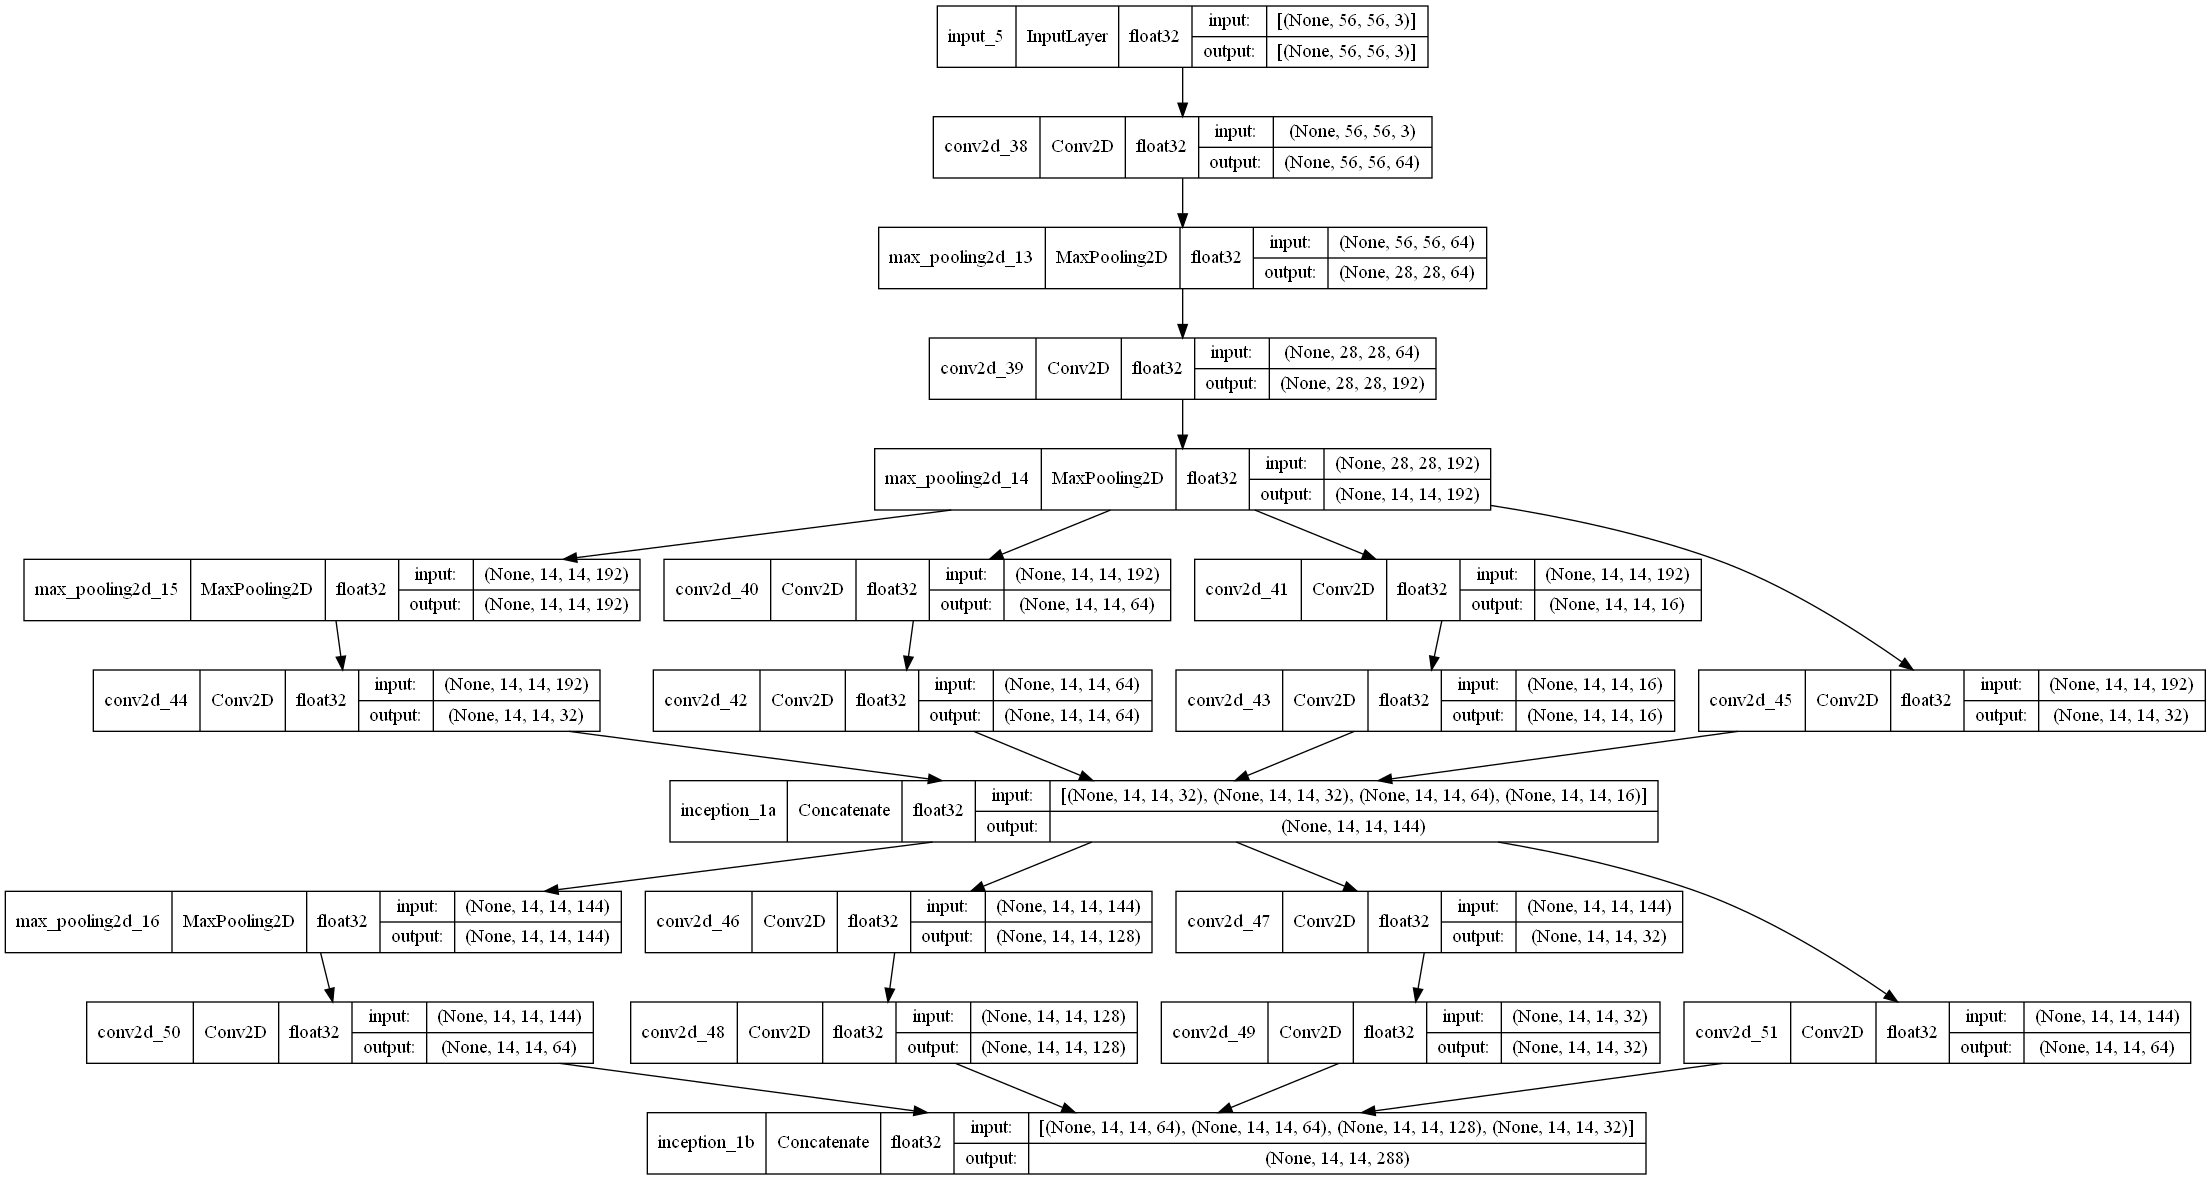

In [10]:
plot_model(exp_inception,
           to_file='inception module.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [3]:
exp_input = Input(shape=(256,256,3))

# conv_7x7
x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', activation=relu)(exp_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

# conv_5x5
x = Conv2D(filters=192, kernel_size=(5,5), padding='same', activation=relu)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

# inception block 1
x = inception_module(x,
                     filter_1x1=64,
                     filter_5x5_reduce=96,
                     filter_3x3=128,
                     filter_3x3_reduce=16,
                     filter_5x5=32,
                     filters_pool_proj=32,
                     name='inception_1a')
x = inception_module(x,
                     filter_1x1=96,
                     filter_5x5_reduce=128,
                     filter_3x3=160,
                     filter_3x3_reduce=32,
                     filter_5x5=48,
                     filters_pool_proj=64,
                     name='inception_1b')

# pooling
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# inception block 2
x = inception_module(x,
                     filter_1x1=128,
                     filter_5x5_reduce=96,
                     filter_3x3=128,
                     filter_3x3_reduce=48,
                     filter_5x5=32,
                     filters_pool_proj=32,
                     name='inception_2a')
x = inception_module(x,
                     filter_1x1=160,
                     filter_5x5_reduce=112,
                     filter_3x3=160,
                     filter_3x3_reduce=32,
                     filter_5x5=64,
                     filters_pool_proj=64,
                     name='inception_2b')
x = inception_module(x,
                     filter_1x1=192,
                     filter_5x5_reduce=128,
                     filter_3x3=128,
                     filter_3x3_reduce=48,
                     filter_5x5=64,
                     filters_pool_proj=64,
                     name='inception_2c')
x = inception_module(x,
                     filter_1x1=256,
                     filter_5x5_reduce=160,
                     filter_3x3=160,
                     filter_3x3_reduce=32,
                     filter_5x5=96,
                     filters_pool_proj=96,
                     name='inception_2d')

# pooling
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# conv 3x3
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# flatten
x = Flatten()(x)

# output layer
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
exp_output = Dense(units=42, activation=softmax)(x)

exp_conv = Model(exp_input, exp_output)
exp_conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

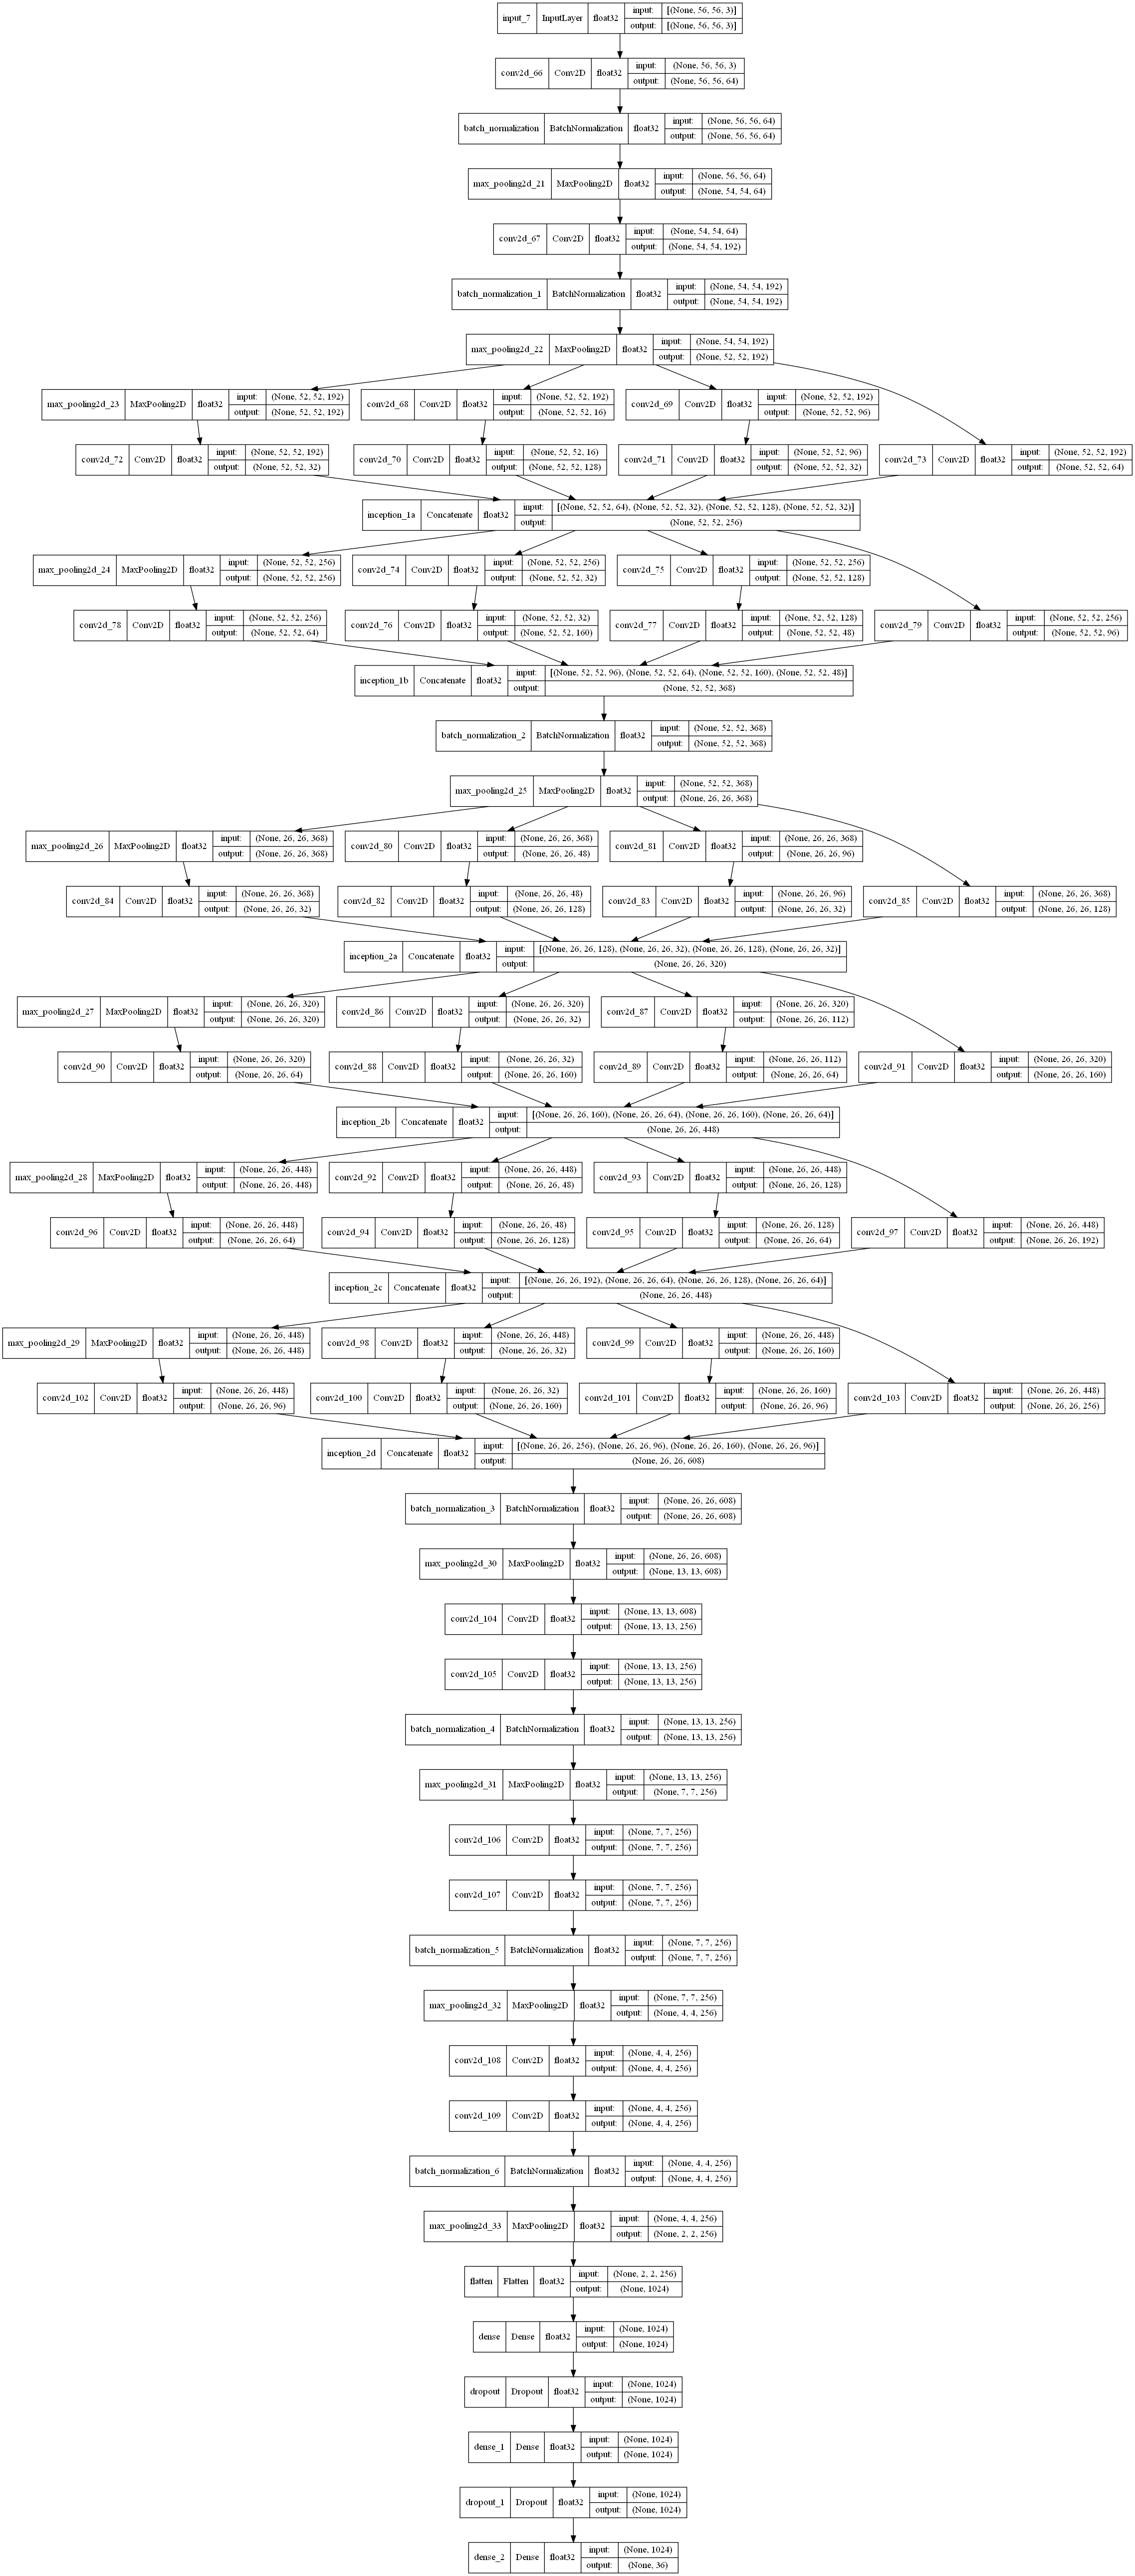

In [13]:
plot_model(exp_conv,
           to_file='modified inception architecture.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)